In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from urllib.request import urlopen

# 1. [Easy] Airdrop Stats

**Bounty:** How many wallets were eligible for the airdrop? How many addresses have claimed the airdrop? What percentage of all ENS that has been airdropped been claimed?

**Conculsion**: There were 97,823 wallets eligible for the airdrop. As of 2021-12-07, 91,229 or 93.26% of eligible wallets have claimed the airdrop. 70.17% of all ENS that has been airdropped been claimed. It is interesting that even though 93% of wallets have claimed the airdrop only 70% of all ENS has been claimed. That must mean that the wallets that are eligible and have not yet claimed their ENS must have larger than typical ENS allocations.

Source: https://ens.mirror.xyz/-eaqMv7XPikvXhvjbjzzPNLS4wzcQ8vdOgi9eNXeUuY


## How many wallets were eligible for the airdrop?

In [2]:
query1 = '''
SELECT
ORIGIN_ADDRESS,
COUNT(DISTINCT TX_ID) as REGISTERED_ENS
FROM ethereum.udm_events
WHERE contract_address = '0x00000000000c2e074ec69a0dfb2997ba6c7d2e1e'    -- ENS Registry Contract
AND origin_function_name = 'registerWithConfig'                          -- Registration function
AND BLOCK_TIMESTAMP <= DATE('2021-10-31')                                -- ENS airdrop cutoff date
GROUP BY ORIGIN_ADDRESS
ORDER BY COUNT(DISTINCT TX_ID) DESC
'''

In [3]:
# Pull query data from API 

url = 'https://api.flipsidecrypto.com/api/v2/queries/5a62fdb1-ecc3-43e4-b322-a0b9a5542935/data/latest'

response = urlopen(url)
data_json = json.loads(response.read())
df = pd.DataFrame(data_json)

In [4]:
df.head()

,ORIGIN_ADDRESS,REGISTERED_ENS
0,0xaa96a50a2f67111262fe24576bd85bb56ec65016,1064
1,0xe68e8cc7ff772b026c062b9cc28246676d044947,932
2,0x2874c4e9cb5f183ef3d8adfa6d6bbd584dc67842,880
3,0xd9c61c6a41cb78ee8124111be112d352a7cf13c1,869
4,0x3e6eb66bfd1046a7ff89a50b26ef6b88af33c317,696


In [5]:
wallet_count = len(df['ORIGIN_ADDRESS'].unique())

print(f'There were {str(wallet_count)} wallets eligible for the airdrop.')

There were 97823 wallets eligible for the airdrop.


## How many addresses have claimed the airdrop?

In [6]:
query2 = '''
SELECT
TX_FROM_ADDRESS,
EVENT_INPUTS,
CURRENT_DATE() as DATE
FROM ethereum.events_emitted
WHERE CONTRACT_ADDRESS = '0xc18360217d8f7ab5e7c516566761ea12ce7f9d72' -- ENS airdrop token contract
AND EVENT_NAME = 'Claim'
AND TX_TO_ADDRESS_NAME = 'ens: ens token'
'''

In [7]:
# Pull query data from API 

url = 'https://api.flipsidecrypto.com/api/v2/queries/021bc945-8ea3-4ac4-bc8a-764cdee80aac/data/latest'

response = urlopen(url)
data_json = json.loads(response.read())
df2 = pd.DataFrame(data_json)

In [8]:
df2.head()

,DATE,EVENT_INPUTS,TX_FROM_ADDRESS
0,2021-12-07T00:00:00Z,"{\n ""account"": ""0x3c87140563845d0d0ee8c4d3016...",0x3c87140563845d0d0ee8c4d301639b1f0ba5758f
1,2021-12-07T00:00:00Z,"{\n ""account"": ""0x7b3f757386cb0a94c5c5c4f24c7...",0x7b3f757386cb0a94c5c5c4f24c70d518c4d63331
2,2021-12-07T00:00:00Z,"{\n ""account"": ""0x319cefeb796f6ea9c99c04f2261...",0x319cefeb796f6ea9c99c04f22617b8168f1f7fd6
3,2021-12-07T00:00:00Z,"{\n ""account"": ""0x607d39aa1e4d169b1f24e429cab...",0x607d39aa1e4d169b1f24e429caba19527211298c
4,2021-12-07T00:00:00Z,"{\n ""account"": ""0xf7318ac0253b14f703d969483ff...",0xf7318ac0253b14f703d969483ff2908b42b261cc


In [9]:
date = df2['DATE'][0][:10]
claim_count = len(df2['TX_FROM_ADDRESS'].unique())
claim_percent = round((claim_count / wallet_count)*100,2)

print(f'As of {date}, {str(claim_count)} or {str(claim_percent)}% of wallets have claimed their airdrop.')

As of 2021-12-07, 91229 or 93.26% of wallets have claimed their airdrop.


## What percentage of all ENS that has been airdropped been claimed?

In [10]:
# Pull out the value from the EVENT_INPUTS field
df2['EVENT_INPUTS'] = [json.loads(x.replace('\n', '')) for x in df2['EVENT_INPUTS']]
df2['event_value'] = [float(x['value']) for x in df2['EVENT_INPUTS']]

In [11]:
claimed_ENS = df2['event_value'].sum()/1e18
total_dropped_ENS = 100000000*.25

claimed_ENS_percent = round((claimed_ENS / total_dropped_ENS)*100,2)

print(f'As of {date}, {str(round(claimed_ENS,2))} or {str(claimed_ENS_percent)}% of airdropped ENS has been claimed')

As of 2021-12-07, 17541651.29 or 70.17% of airdropped ENS has been claimed


# Data Visualization

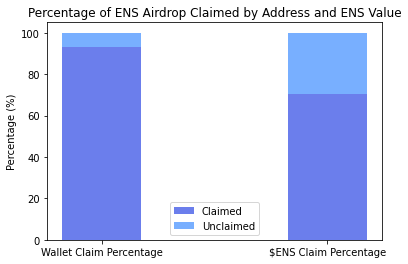

In [12]:
import matplotlib.pyplot as plt

labels = ['Wallet Claim Percentage', '$ENS Claim Percentage']
claimed = [claim_percent, claimed_ENS_percent]
unclaimed = [100-claim_percent, 100- claimed_ENS_percent]

width = 0.35

fig, ax = plt.subplots()

ax.bar(labels, claimed, width, label='Claimed', color = '#6b7eec')
ax.bar(labels, unclaimed, width, bottom=claimed, label='Unclaimed', color = '#78afff')

ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage of ENS Airdrop Claimed by Address and ENS Value')
ax.legend()

plt.show()